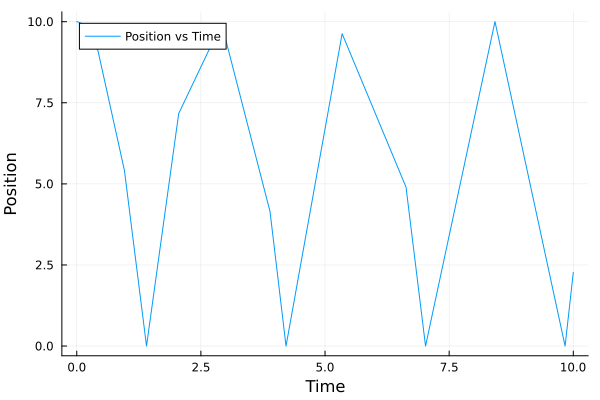

In [1]:
using DifferentialEquations, Plots

# Define the bouncing ball system
function bouncing_ball(du, u, p, t)
    g = p[1]  # gravity constant
    b = p[2]  # air friction constant
    
    du[1] = u[2]  # velocity
    du[2] = -g - b * u[2]^2  # acceleration
end

# Define the event when the ball hits the table
function event_bounce(u, t, integrator)
    u[1]  # The event happens when the position reaches 0
end

# Define the condition for the event
function condition_bounce(u, t, integrator)
    u[1]  # The event happens when the position reaches 0
end

# Define the effect of the event (reversing the velocity)
function affect_bounce!(integrator)
    integrator.u[2] = -integrator.u[2]  # Reverse the velocity
end

# Set up the initial conditions and parameters
u0 = [10.0, 0.0]  # initial position and velocity
tspan = (0.0, 10.0)  # time span
p = (9.8, 0.01)  # gravity constant and air friction constant

# Set up the ODE problem
prob = ODEProblem(bouncing_ball, u0, tspan, p)

# Set up the continuous callback for bouncing
cb = ContinuousCallback(event_bounce, condition_bounce, affect_bounce!)

# Solve the ODE problem with the callback
sol = solve(prob, callback=cb)

# Plot the time evolution of position versus time
plot(sol.t, sol[1,:], xlabel="Time", ylabel="Position", label="Position vs Time", legend=:topleft)


In [3]:
using Distributions

function my_quantile(d::UnivariateDistribution, q::Number; tol=1e-6, max_iter=100)
    θ₀ = median(d)
    θ = θ₀
    
    cdf_val = cdf(d, θ)
    pdf_val = pdf(d, θ)
    
    iter = 0
    while abs(cdf_val - q) > tol && iter < max_iter
        θ -= (cdf_val - q) / pdf_val
        cdf_val = cdf(d, θ)
        pdf_val = pdf(d, θ)
        iter += 1
    end
    
    if iter == max_iter
        error("Maximum number of iterations reached")
    end
    
    return θ
end

# Test the function with different distributions
distributions = [Gamma(5, 1), Normal(0, 1), Beta(2, 4)]
quantiles = [0.25, 0.5, 0.75]

for dist in distributions
    println("Distribution: ", dist)
    for q in quantiles
        println("My quantile at q=$q: ", my_quantile(dist, q))
        println("Distributions.jl quantile at q=$q: ", quantile(dist, q))
    end
    println()
end


Distribution: Gamma{Float64}(α=5.0, θ=1.0)
My quantile at q=0.25: 3.3686003893861183
Distributions.jl quantile at q=0.25: 3.3686003859773215
My quantile at q=0.5: 4.670908882795985
Distributions.jl quantile at q=0.5: 4.670908882795985
My quantile at q=0.75: 6.274430698355646
Distributions.jl quantile at q=0.75: 6.274430698444688

Distribution: Normal{Float64}(μ=0.0, σ=1.0)
My quantile at q=0.25: -0.6744895718136282
Distributions.jl quantile at q=0.25: -0.6744897501960818
My quantile at q=0.5: 0.0
Distributions.jl quantile at q=0.5: 0.0
My quantile at q=0.75: 0.6744895718136281
Distributions.jl quantile at q=0.75: 0.6744897501960818

Distribution: Beta{Float64}(α=2.0, β=4.0)
My quantile at q=0.25: 0.1937636095991362
Distributions.jl quantile at q=0.25: 0.19376360955397115
My quantile at q=0.5: 0.3138101704556974
Distributions.jl quantile at q=0.5: 0.3138101704556974
My quantile at q=0.75: 0.45418023456043105
Distributions.jl quantile at q=0.75: 0.4541805647736157



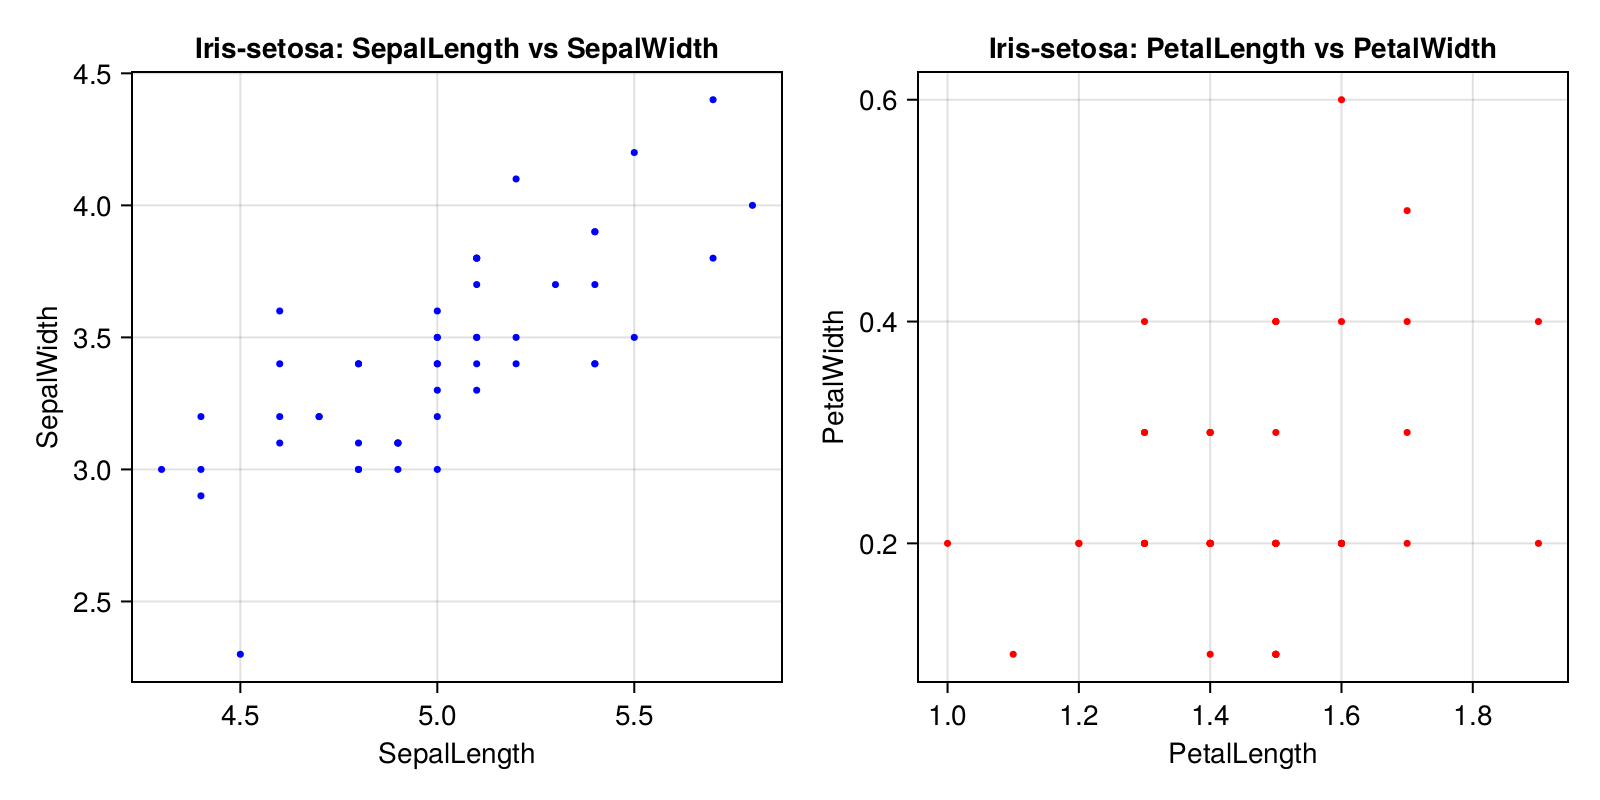

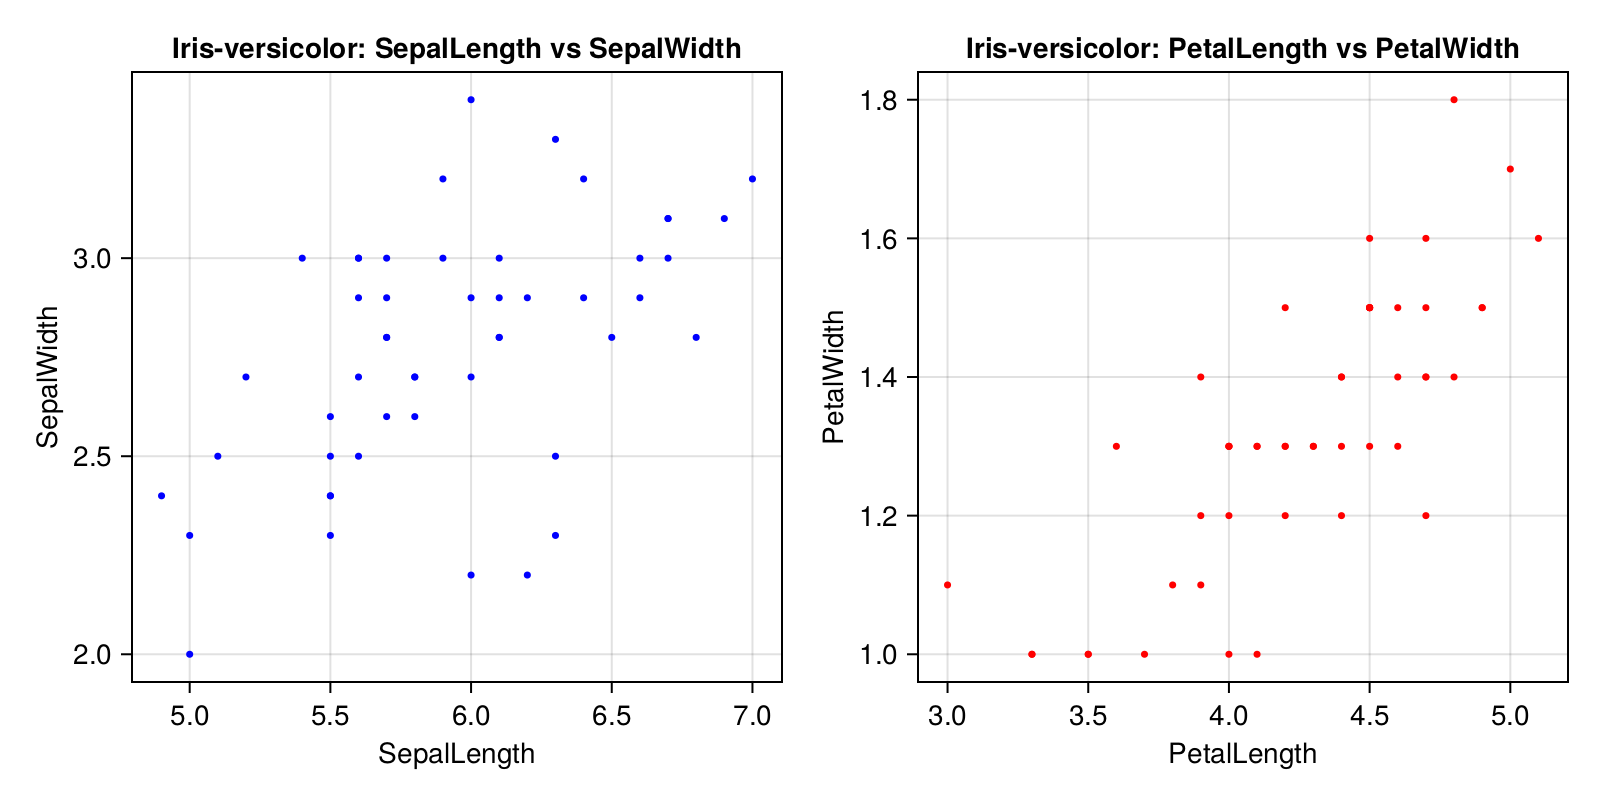

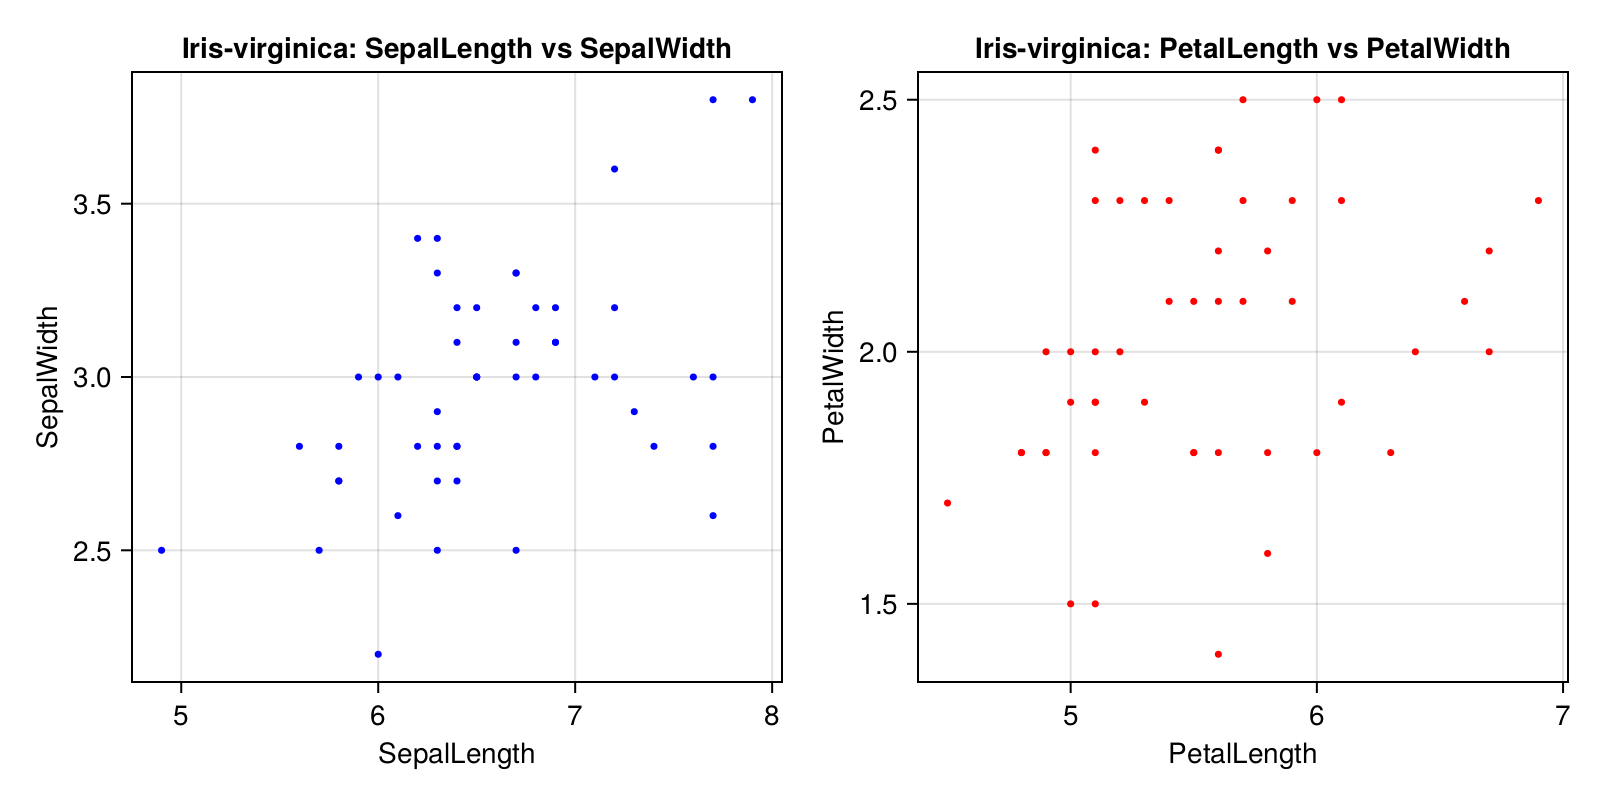

In [1]:
using DataFrames, CSV
using CairoMakie

# Load the Iris dataset
iris = DataFrame(CSV.File(joinpath(dirname(pathof(DataFrames)), "../docs/src/assets/iris.csv")))

# Get unique species in the dataset
species = unique(iris[:, :Species])

# Create a 1x2 figure for each species
for specie in species
    # Filter the dataset for the current specie
    specie_data = filter(row -> row.Species == specie, iris)
    
    # Create a 1x2 figure
    fig = Figure(size = (800, 400))
    
    # Scatter plot of SepalLength vs SepalWidth
    ax1 = Axis(fig[1, 1])
    scatter!(ax1, specie_data.SepalLength, specie_data.SepalWidth, markersize = 5, color = :blue)
    ax1.xlabel = "SepalLength"
    ax1.ylabel = "SepalWidth"
    ax1.title = "$specie: SepalLength vs SepalWidth"
    
    # Scatter plot of PetalLength vs PetalWidth
    ax2 = Axis(fig[1, 2])
    scatter!(ax2, specie_data.PetalLength, specie_data.PetalWidth, markersize = 5, color = :red)
    ax2.xlabel = "PetalLength"
    ax2.ylabel = "PetalWidth"
    ax2.title = "$specie: PetalLength vs PetalWidth"
    
    # Show the figure
    display(fig)
end




In [4]:
using DynamicalSystems, DataFrames

# Define the Roessler system
function roessler(du, u, p, t)
    du[1] = -u[2] - u[3]
    du[2] = u[1] + p[1] * u[2]
    du[3] = p[2] + u[3] * (u[1] - p[3])
end

# Define parameter ranges
as = 0.15:0.025:0.25
bs = 0.15:0.025:0.25
cs = 4:0.1:6.0

# Initialize DataFrame
df = DataFrame(a = Float64[], b = Float64[], c = Float64[], λ1 = Float64[], λ3 = Float64[], H = Float64[])

# Loop over parameter ranges
for a in as
    for b in bs
        for c in cs
            # Define initial condition
            u0 = ones(3)
            
            # Define parameters
            p = [a, b, c]
            
            # Create DynamicalSystem
            ds = ContinuousDynamicalSystem(roessler, u0, p)
            
            # Calculate Lyapunov spectrum
            λs = lyapunovspectrum(ds)
            λ1, λ3 = λs[1], λs[end]
            
            # Simulate trajectory to estimate entropy
            trajectory = trajectory(ds, 10000.0; dt = 0.1)
            ε = 0.1
            histogram = ValueHistogram(ε)
            H = entropy(histogram, trajectory)
            
            # Push results to DataFrame
            push!(df, (a = a, b = b, c = c, λ1 = λ1, λ3 = λ3, H = H))
        end
    end
end

# Perform queries
chaotic_sets = filter(row -> row.λ1 > 0.01, df)
λ_vs_H = select(chaotic_sets, [:λ1, :H])
heatmap_data = filter(row -> row.a == 0.2, chaotic_sets)
unstacked = unstack(heatmap_data, :b, :H; renamecols = (x -> "H for b=$(x)"))
heat = Matrix(unstacked[:, Not(:c)])


Precompiling DynamicalSystems
  ✗ PyCall
  ✗ SciMLBase → SciMLBasePyCallExt
  ✓ Roots → RootsIntervalRootFindingExt
  ✓ HypothesisTests
  ✓ FractalDimensions
  ✓ TimeseriesSurrogates → TimeseriesSurrogatesVisualizations
  ✓ DynamicalSystemsBase
  ✓ PredefinedDynamicalSystems
  ✓ ChaosTools
  ✓ Attractors
  ✓ Attractors → AttractorsVisualizations
  ✓ DynamicalSystems
  ✓ DynamicalSystems → DynamicalSystemsVisualizations
  11 dependencies successfully precompiled in 111 seconds. 397 already precompiled.
[ Info: Precompiling DynamicalSystems [61744808-ddfa-5f27-97ff-6e42cc95d634]
ERROR: LoadError: UndefVarError: `where_bisect` not defined
Stacktrace:
 [1] getproperty(x::Module, f::Symbol)
   @ Base .\Base.jl:31
 [2] top-level scope
   @ C:\Users\Rainer\.julia\packages\IntervalRootFinding\gKaGR\src\IntervalRootFinding.jl:40
 [3] include
   @ Base .\Base.jl:495 [inlined]
 [4] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String},

    @ FileWatching.Pidfile C:\Users\Rainer\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32\share\julia\stdlib\v1.10\FileWatching\src\pidfile.jl:93
  [6] #mkpidlock#6
    @ FileWatching.Pidfile C:\Users\Rainer\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32\share\julia\stdlib\v1.10\FileWatching\src\pidfile.jl:88 [inlined]
  [7] trymkpidlock(::Function, ::Vararg{Any}; kwargs::@Kwargs{stale_age::Int64})
    @ FileWatching.Pidfile C:\Users\Rainer\.julia\juliaup\julia-1.10.0+0.x64.w64.mingw32\share\julia\stdlib\v1.10\FileWatching\src\pidfile.jl:111
  [8] #invokelatest#2
    @ Base .\essentials.jl:889 [inlined]
  [9] invokelatest
    @ Base .\essentials.jl:884 [inlined]
 [10] maybe_cachefile_lock(f::Base.var"#968#969"{Base.PkgId}, pkg::Base.PkgId, srcpath::String; stale_age::Int64)
    @ Base .\loading.jl:2977
 [11] maybe_cachefile_lock
    @ Base .\loading.jl:2974 [inlined]
 [12] _require(pkg::Base.PkgId, env::String)
    @ Base .\loading.jl:1964
 [13] __require_prelocked(uuidkey::Base.PkgId, e

LoadError: Failed to precompile DynamicalSystems [61744808-ddfa-5f27-97ff-6e42cc95d634] to "C:\\Users\\Rainer\\.julia\\compiled\\v1.10\\DynamicalSystems\\jl_1B16.tmp".